In [ ]:
import numpy as np
import torch
import torch.nn as nn
from numba import njit, prange
from Bio import SeqIO
import os

def read_tensor_from_txt(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Read the dimensions from the first line
    dims = list(map(int, lines[0].strip().split()))
    
    tensor_data = []
    current_slice = []
    for line in lines[1:]:
        line = line.strip()
        if line.startswith("Slice"):
            if current_slice:
                tensor_data.append(current_slice)
                current_slice = []
        elif line:
            current_slice.append(list(map(float, line.split(','))))
    if current_slice:
        tensor_data.append(current_slice)

    tensor = torch.tensor(tensor_data).view(*dims)
    return tensor


#######################################################
# 2) The multi-domain sub-block model
#######################################################
class MultiDomainAttentionSubBlock(nn.Module):
    """
    A single-layer attention model that splits H heads among 3 groups:
      - Domain1 heads => Q1,K1,V1
      - Domain2 heads => Q2,K2,V2
      - Inter-domain heads => Qint1,Kint1,Vint1 (domain1->domain2),
                              Qint2,Kint2,Vint2 (domain2->domain1)
    """
    def __init__(
        self,
        H=32,          # total heads
        d=23,          # dimension for Q,K
        N=176,         # total protein length
        q=22,          # amino-acid alphabet
        lambd=0.001,
        domain1_end=63, 
        H1=10, 
        H2=20, 
        device='cpu'
    ):
        super().__init__()
        self.H = H
        self.d = d
        self.N = N
        self.q = q
        self.lambd = lambd
        self.device = device

        # domain1 is [0..domain1_end], length => N_alpha
        self.domain1_end = domain1_end
        self.domain2_start = domain1_end + 1
        self.N_alpha = self.domain2_start
        self.N_beta = self.N - self.N_alpha

        self.H1 = H1
        self.H2 = H2

        # (1) Domain1 heads
        self.Q1 = nn.Parameter(torch.randn(H1, d, self.N_alpha, device=self.device))
        self.K1 = nn.Parameter(torch.randn(H1, d, self.N_alpha, device=self.device))
        self.V1 = nn.Parameter(torch.randn(H1, q, q, device=self.device))

        # (2) Domain2 heads
        num_dom2_heads = self.H2 - self.H1
        self.Q2 = nn.Parameter(torch.randn(num_dom2_heads, d, self.N_beta, device=self.device))
        self.K2 = nn.Parameter(torch.randn(num_dom2_heads, d, self.N_beta, device=self.device))
        self.V2 = nn.Parameter(torch.randn(num_dom2_heads, q, q, device=self.device))

        # (3) Inter-domain heads
        num_inter_heads = self.H - self.H2
        num_inter_heads1 = num_inter_heads // 2  # domain1->domain2
        num_inter_heads2 = num_inter_heads - num_inter_heads1  # domain2->domain1

        self.Qint1 = nn.Parameter(torch.randn(num_inter_heads1, d, self.N_alpha, device=self.device))
        self.Kint1 = nn.Parameter(torch.randn(num_inter_heads1, d, self.N_beta, device=self.device))
        self.Vint1 = nn.Parameter(torch.randn(num_inter_heads1, q, q, device=self.device))

        self.Qint2 = nn.Parameter(torch.randn(num_inter_heads2, d, self.N_beta, device=self.device))
        self.Kint2 = nn.Parameter(torch.randn(num_inter_heads2, d, self.N_alpha, device=self.device))
        self.Vint2 = nn.Parameter(torch.randn(num_inter_heads2, q, q, device=self.device))

    def forward(self, Z, weights, head_group='all'):
        """
        Normally you do partial updates. We'll skip the forward logic here 
        since we only want the sub-block parameters for the energy test.
        """
        return None

letter_to_num = {
    'A': 1,  'C': 2,  'D': 3,  'E': 4,
    'F': 5,  'G': 6,  'H': 7,  'I': 8,
    'K': 9,  'L': 10, 'M': 11, 'N': 12,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16,
    'T': 17, 'V': 18, 'W': 19, 'Y': 20,
    '-': 21,
    'B': 21, 'J': 21, 'O': 21, 'U': 21,
    'X': 21, 'Z': 21
}

def tokenize_msa(MSA, letter_to_num):
    N, L = MSA.shape
    out = np.zeros((N, L), dtype=np.uint16)
    for i in range(N):
        for j in range(L):
            char = MSA[i,j]
            if char in letter_to_num:
                out[i,j] = letter_to_num[char]
            else:
                out[i,j] = letter_to_num['-']
    return out

@njit(parallel=True)
def bulk_energy_domain12(seqABs, Q, K, V, L1, d):
    # same code as you had
    N_pairs = seqABs.shape[0]
    L2 = K.shape[2]
    H = Q.shape[0]
    energies = np.zeros(N_pairs, dtype=np.float32)

    for n in prange(N_pairs):
        seqAB = seqABs[n]
        seqA = seqAB[:L1]
        seqB = seqAB[L1:]

        e_sel = np.zeros((L1, L2, H), dtype=np.float32)
        for h_ in range(H):
            for i_ in range(L1):
                for j_ in range(L2):
                    val = 0.0
                    for dd in range(d):
                        val += Q[h_, dd, i_]*K[h_, dd, j_]
                    e_sel[i_, j_, h_] = val

        # softmax over j
        for i_ in range(L1):
            for h_ in range(H):
                row = e_sel[i_, :, h_]
                maxv = -1e20
                for j_ in range(L2):
                    if row[j_]>maxv: maxv=row[j_]
                sumexp=0.0
                for j_ in range(L2):
                    x = np.exp(row[j_]-maxv)
                    row[j_] = x
                    sumexp += x
                for j_ in range(L2):
                    row[j_]/= sumexp

        # multiply by V[h,a_i,a_j]
        E_val=0.0
        for i_ in range(L1):
            a_i = seqA[i_]
            for j_ in range(L2):
                a_j = seqB[j_]
                for h_ in range(H):
                    E_val += e_sel[i_, j_, h_]*V[h_,a_i,a_j]
        energies[n] = E_val

    return energies




def test_interdomain_energy_numba(MSA_A, MSA_B, Q_np, K_np, V_np, L1, d):
    N_A = MSA_A.shape[0]
    N_B = MSA_B.shape[0]
    L2 = MSA_B.shape[1]
    N_pairs = N_A*N_B

    seqABs = np.zeros((N_pairs, L1+L2), dtype=np.uint16)
    correct_flags = np.zeros(N_pairs, dtype=np.bool_)

    idx=0
    for i in range(N_A):
        for j in range(N_B):
            seqA = MSA_A[i]
            seqB = MSA_B[j]
            seqAB = np.concatenate([seqA, seqB])
            seqABs[idx] = seqAB
            is_correct = (i==j)
            correct_flags[idx]=is_correct
            idx+=1

    energies = bulk_energy_domain12(seqABs, Q_np, K_np, V_np, L1, d)
    corr_scores = energies[correct_flags]
    incorr_scores = energies[~correct_flags]
    return corr_scores, incorr_scores

def paired_fasta_to_labeled_array(fasta_name, L_A):
    seqs=[]
    for record in SeqIO.parse(fasta_name, "fasta"):
        seqs.append(list(str(record.seq)))
    seqs=np.array(seqs) # shape (N, L_A+L_B)
    MSA_A = seqs[:,:L_A]
    MSA_B = seqs[:,L_A:]
    return MSA_A, MSA_B

# -- MAIN usage snippet --
# (A) Suppose we read Qint1,Kint1,Vint1,... from disk
cwd = os.getcwd()
H=160
d=10
N=174
q=22
domain1_end=63
H1=25
H2=H1+15
family = 'HKRR_25_15_120_JUSTdomain1to2update_withdomain1training_withHKRRtrainingfasta_d10_500batch'
n_epochs=1000
loss_type="without_J"
# read them:
Qint1 = read_tensor_from_txt( f"{cwd}/results/{H}_{d}_{family}_{loss_type}_{n_epochs}/Qint1_tensor.txt" )
Kint1 = read_tensor_from_txt( f"{cwd}/results/{H}_{d}_{family}_{loss_type}_{n_epochs}/Kint1_tensor.txt" )
Vint1 = read_tensor_from_txt( f"{cwd}/results/{H}_{d}_{family}_{loss_type}_{n_epochs}/Vint1_tensor.txt" )

device='cpu'
model = MultiDomainAttentionSubBlock(
    H=H, d=d, N=N, q=q,
    domain1_end=domain1_end,
    H1=H1, H2=H2,
    device=device
).to(device)
# assign them:
model.Qint1.data = Qint1
model.Kint1.data = Kint1
model.Vint1.data = Vint1

# Suppose Qint1: shape (#heads_int1, d, L1)
# We'll convert them to numpy:
Q_np = Qint1.detach().cpu().numpy()
K_np = Kint1.detach().cpu().numpy()
V_np = Vint1.detach().cpu().numpy()
L_A = model.N_alpha
test_fasta = f"{cwd}/CODE/DataAttentionDCA/data/lisa_data/HK-RR_174_test.fasta"
    # shape => (N, L_A)/(N,L_B)
    # Now tokenize
MSA_A, MSA_B = paired_fasta_to_labeled_array(test_fasta, L_A=L_A)
MSA_A = tokenize_msa(MSA_A, letter_to_num)
MSA_B = tokenize_msa(MSA_B, letter_to_num)
corr_scores, incorr_scores = test_interdomain_energy_numba(
   MSA_A, MSA_B,
   Q_np, K_np, V_np,
   L_A, d
)
print("Correct shape:", corr_scores.shape)
print("Incorrect shape:", incorr_scores.shape)




In [2]:
incorr_scores.shape

(13195056,)

In [ ]:
# File path to save the arrays
file_path = "scores.txt"

# Save arrays to a text file
with open(file_path, "w") as file:
    # Save correct scores
    file.write(",".join(map(str, corr_scores)) + "\n")
    # Save incorrect scores
    file.write(",".join(map(str, incorr_scores)) + "\n")

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_21317/4116255529.py:2: SyntaxWarning: invalid escape sequence '\s'
  file_path = ".\scores.txt"


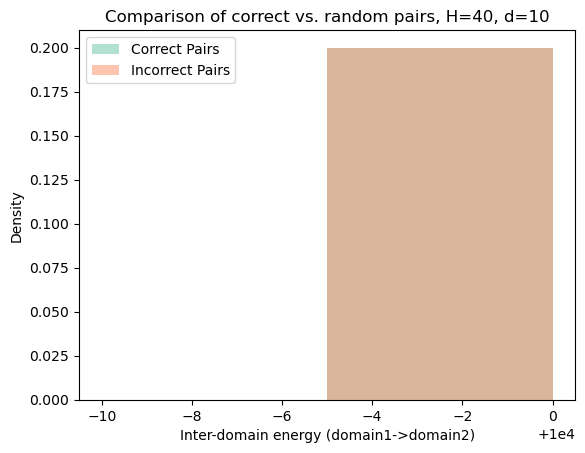

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
mypalette=sns.color_palette("Set2")
plt.figure()
bin_width=5
def_val=1e5  # if you used a default penalty for mismatched species, etc.
# Exclude any huge def_val if you do species checks
incorr_scores = incorr_scores[incorr_scores < def_val]
minval = min(corr_scores.min(), incorr_scores.min())
maxval = max(corr_scores.max(), incorr_scores.max())
bins = np.arange(9990, 10000+ bin_width, bin_width)
plt.hist(corr_scores, bins=bins, alpha=0.5, label="Correct Pairs", color=mypalette[0], density=True)
plt.hist(incorr_scores, bins=bins, alpha=0.5, label="Incorrect Pairs", color=mypalette[1], density=True)
plt.xlabel("Inter-domain energy (domain1->domain2)")
plt.ylabel("Density")
plt.title(f"Comparison of correct vs. random pairs, H={Qint1.shape[0]}, d={d}")
plt.legend()
plt.show()